# Introduction

This project, based on **OMSCS7650 Natural Language Processing**, explores the attention mechanism in a **question-answering (QA) task**, comparing **multihot** and **GloVe** implementations using a **Key-Value Memory Network (KVMemNet)**.

Unlike traditional Knowledge Bases, KVMemNet learns to access an external memory store—organized as keys and values—without encoding all information directly into the model parameters, allowing updates without retraining.
Given a question, the model computes similarity between the question and memory keys, applies an attention-scoring mechanism to select relevant keys, and uses the corresponding values to predict the answer. This single-hop design supports end-to-end learning and illustrates self-attention concepts without the full complexity of transformers.

# Disclaimer

The code preceding Step 2 is adapted and modified from **OMSCS7650: Natural Language Processing**.

# Libraries



In [1]:
!pip install unidecode
import unidecode

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import re
import os
import json
import random
import numpy as np
import pickle
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from math import ceil
import time
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from IPython.display import display, HTML

'''
The file private_models contains KVMemNet model implementations used in this project.

For academic integrity, it is not included in this repository because the course
OMSCS 7650: Natural Language Processing may still use this topic for assignments.

Upon request for demonstration for employment or other legitimate purposes,
the author may provide it privately.
'''

from private_models import PrivateModels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 4.1 MB/s eta 0:00:00


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Pre-process Functions on Raw Data

In [3]:
# Stemming
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= [ps.stem(word) for word in text]
    return text

In [4]:
# Tokenization (keep letters and numbers)
def tokenize(line):
    line = re.sub(r'[^a-zA-Z0-9]', ' ', unidecode.unidecode(line))
    line = line.lower().split()
    return line

In [5]:
# Standard vocabulary object class
class Vocab:
    def __init__(self, name = 'vocab'):
        self.name = name
        self._word2index = {}
        self._word2count = {}
        self._index2word = {}
        self._n_words = 0
        self.add_word(UNK)

    def get_words(self):
      return list(self._word2count.keys())

    def num_words(self):
      return self._n_words

    def word2index(self, word):
      return self._word2index.get(word, UNK_ID)

    def index2word(self, index):
      return self._index2word.get(index, UNK)

    def word2count(self, word):
      return self._word2count.get(word, 0)

    def add_sentence(self, sentence):
        for word in tokenize(sentence):
            self.add_word(word)

    def add_word(self, word):
        if word not in self._word2index:
            self._word2index[word] = self._n_words
            self._word2count[word] = 1
            self._index2word[self._n_words] = word
            self._n_words += 1
        else:
            self._word2count[word] += 1

In [6]:
# Multihot: Make a bag of words from a sentence (s), given a vocabulary (vocab)
# Either return a bag of word counts or a bag of word presences.
def multihot(s, vocab, preserve_counts = False):
  tokens = np.array([vocab.word2index(t) for t in tokenize(s)])
  mhot = np.zeros((tokens.size, vocab.num_words()))
  mhot[np.arange(tokens.size), tokens] = 1
  if preserve_counts:
    return mhot.sum(0)
  else:
    return mhot.sum(0) >= 1

In [7]:
# For vocabulary, create an unknown "unk" token with token index in the vocabulary (UNK_ID).
UNK = 'unk'
UNK_ID = 0

# Step 1: Download & Process Data

Data link: https://github.com/DavidGrangier/wikipedia-biography-dataset

The raw data contains the information in tables that are commonly used in Wikipedia biography pages. Each entity (i.e., each person) has different rows of information and details.

For example, [Alexander Hamilton](https://en.wikipedia.org/wiki/Alexander_Hamilton) has information about birth date, death date, spouse, political party, etc, which are the **keys**. The value of a key like **birth date** is the specific value like **11 january 1755**. **keys** are also called **relations** in this project.

After pre-processing, two things are created from the raw data:
- **`DB`**: a hash table that map titles of biography wikipedia articles to table information. The table information is represented as a nested hash table containing relations as keys, and associated values. For example, \
`DB['alexander hamilton'] = {'birth_date': '11 january 1755','party': 'federalist', ...}`

- **`VOCAB`**: A vocabulary object that maps words to tokens and vice versa.

In [8]:
!git clone https://github.com/rlebret/wikipedia-biography-dataset.git

Cloning into 'wikipedia-biography-dataset'...
remote: Enumerating objects: 93, done.
remote: Total 93 (delta 0), reused 0 (delta 0), pack-reused 93 (from 1)
Receiving objects: 100% (93/93), 338.68 MiB | 25.98 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Updating files: 100% (19/19), done.


In [9]:
# Decompressing zip files
!cat wikipedia-biography-dataset/wikipedia-biography-dataset.z?? > tmp.zip
!unzip -o tmp.zip
!rm tmp.zip

Archive:  tmp.zip
   creating: wikipedia-biography-dataset/test/
  inflating: wikipedia-biography-dataset/test/test.box  
  inflating: wikipedia-biography-dataset/test/test.id  
  inflating: wikipedia-biography-dataset/test/test.nb  
  inflating: wikipedia-biography-dataset/test/test.sent  
  inflating: wikipedia-biography-dataset/test/test.url  
  inflating: wikipedia-biography-dataset/test/test.contributors  
  inflating: wikipedia-biography-dataset/test/test.title  
   creating: wikipedia-biography-dataset/train/
  inflating: wikipedia-biography-dataset/train/train.box  
  inflating: wikipedia-biography-dataset/train/train.id  
  inflating: wikipedia-biography-dataset/train/train.nb  
  inflating: wikipedia-biography-dataset/train/train.sent  
  inflating: wikipedia-biography-dataset/train/train.url  
  inflating: wikipedia-biography-dataset/train/train.contributors  
  inflating: wikipedia-biography-dataset/train/train.title  
   creating: wikipedia-biography-dataset/valid/
  infla

In [10]:
# Clean titles
def clean_title(title):
    title = re.sub(r'-lrb-.*?-rrb-', '', title, flags=re.IGNORECASE)
    title = re.sub(r'\s+([,.])', r'\1', title)  # Remove space before punctuation
    title = re.sub(r'\.\s*\.', '.', title)      # Replace ". ." with "."
    title = re.sub(r'\s+', ' ', title)          # Normalize spaces

    # Keep only the part before the first comma
    if ',' in title:
        title = title.split(',')[0].strip()

    return title

# Get wikipedia titles (cleaned)
train_titles = []
with open("wikipedia-biography-dataset/train/train.title", "r") as file:
    for line in file:
        cleaned = clean_title(line.rstrip())
        train_titles.append(cleaned)

In [11]:
# Get boxes, which contain all the information - each line corresponds to a wikipedia title.
train_boxes = []
with open("wikipedia-biography-dataset/train/train.box", "r") as file:
  for line in file:
    train_boxes.append(line.rstrip())

In [12]:
# Only keeps the entities containing "office" key term
# Make a dictionary of dictionaries
def make_db(titles, boxes):
  db = {} # The DB
  # Iterate through titles
  for i in tqdm(range(len(titles))):
    box = boxes[i] # Grab the corresponding box information
    d  = {} # Inner dictionary
    # Build a dict for the ith entry
    # grab each key:value pair
    for pair in re.findall(r'([a-zA-Z_]+)[0-9]*\:([\w\d]+)', box):
      key, value = pair
      # Do a bit of cleaning
      key = key.strip()
      value = value.strip()
      # If the key contains the word image, we probably don't want to keep it
      if 'image' not in key:
        # The regex maintains underscores, strip those off
        if key[-1] == '_':
          key = key[:-1]
        # Make a new entry in inner dictionary if we don't have one
        if key not in d:
          d[key] = value
        # Keys with compound values are split up, which is annoying, so put them back together
        else:
          d[key] += ' ' + value
    # If it has an office key, keep it.
    if 'office' in d:
      db[titles[i]] = d
  return db

In [13]:
# Build vocab from DB
def make_vocab(DB):
  # Make the vocab object
  vocab = Vocab()
  # Tokenize the data by converting the entire DB into a string
  tokens = tokenize(str(DB))
  # Iterate through all the tokens (tqdm provides a progress bar)
  for t in tqdm(tokens):
    vocab.add_word(t)
  return vocab

In [14]:
# Reduce vocabulary by discarding rare words
def reduce_vocab(vocab, min_word_occurrence):
  # make a new vocab
  vocab2 = Vocab("top")
  # Add the UNK token
  vocab2.add_word(UNK)
  # Iterate through vocabulary
  for w in list(vocab._word2count.keys()):
    count = vocab._word2count[w]
    idx = vocab._word2index[w]
    # If the word count passes threshold, add it to the new vocabulary object
    if count >= min_word_occurrence:
      vocab2.add_word(w)
      vocab2._word2count[w] = count
  # Return the new vocabulary object
  return vocab2

In [15]:
# Create DB
DB = make_db(train_titles, train_boxes)
len(DB)

100%|██████████| 582659/582659 [00:56<00:00, 10235.68it/s]


40520

In [16]:
# Create VOCAB
VOCAB = make_vocab(DB)
VOCAB.num_words()

100%|██████████| 2961869/2961869 [00:01<00:00, 1946947.74it/s]


95897

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
# Save DB & VOCAB to drive
with open("drive/MyDrive/NLP/DB", "wb") as f:
  pickle.dump(DB, f, protocol=None, fix_imports=True, buffer_callback=None)

with open('drive/MyDrive/NLP/VOCAB', 'wb') as f:
    pickle.dump(VOCAB, f, protocol=None, fix_imports=True, buffer_callback=None)

In [19]:
# Load DB & VOCAB
with open("drive/MyDrive/NLP/DB", "rb") as f:
  DB = pickle.load(f)

with open("drive/MyDrive/NLP/VOCAB", "rb") as f:
  VOCAB = pickle.load(f)

In [20]:
# Examine the entry in DB
DB['chris watson']

{'name': 'chris watson',
 'order': '3rd prime minister of australia elections 1903 1906',
 'term_start': '27 april 1904 27 april 1904 20 may 1901 18 august 1904 8 november 1906 30 march 1901',
 'term_end': '18 august 1904 17 august 1904 30 october 1907 5 july 1905 13 april 1910 12 december 1906',
 'monarch': 'edward vii',
 'predecessor': 'alfred deakin sir george turner george reid george edwards constituency created',
 'successor': 'george reid sir george turner andrew fisher george reid edward riley constituency abolished',
 'office': 'treasurer of australia 1st leader of the labor party leader of the opposition member of the australian parliament for south sydney member of the australian parliament for bland',
 'primeminister': 'chris watson',
 'deputy': 'gregor mcgregor',
 'birth_name': 'john christian tanck',
 'birth_date': 'c 9 april 1867',
 'birth_place': 'valparaíso chile',
 'death_date': '18 november 1941',
 'death_place': 'sydney new south wales australia',
 'party': 'austral

# Step 2: Build Key-Value Memory Network

**Question Answering (QA)** systems have traditionally relied on structured **Knowledge Bases (KBs)** like Freebase to retrieve answers, as their schema-driven organization makes logical queries tractable.

However, KBs are inherently incomplete and rigid to handle the richness and diversity of information found in natural text sources like Wikipedia. As a result, there's growing interest in designing models capable of reading unstructured documents directly and answering questions from them.


To tackle this challenge, the **Key-Value Memory Network (KVMemNet) model** was introduced. It enhances the original Memory Network by separating the addressing and reading phases using distinct **key-value representations**. In this architecture, both the question and memory slots (facts) are represented as bag-of-words and embedded into a shared vector space. Keys help match the question to relevant memory slots, while values provide the corresponding answer representations.

The KVMemNet performs a soft attention mechanism over the keys to compute relevance scores, then uses these scores to produce a weighted sum of the values—yielding a final feature vector that leads to the predicted answer. Unlike rigid KB queries, this approach supports neural reasoning over text, enabling end-to-end learning with standard backpropagation. It also generalizes to multi-hop reasoning, where the model refines its internal query vector through repeated attention rounds.

This project focuses on implementing a single-hop version of KVMemNet, where a question is matched to the best key, and the corresponding value is used to form the prediction. The design is well-suited for tasks where symbolic queries over structured KBs are not feasible, and the goal is to extract information from raw, potentially noisy, textual inputs.

Key-value memory networks are described in this [paper](https://arxiv.org/abs/1606.03126).

In [21]:
'''
KVMemNet model is defined in private_models.PrivateModels for this project.
The implementation is hidden for academic integrity.
'''
KVMemNet = PrivateModels.KVMemNet

# Step 3: Training and Testing Datasets

In [22]:
# Examine the top-k most frequent relations in DB

k = 15

# Count all relation frequencies (excluding 'name')
relation_cnt = Counter()
for entry in DB.values():
    relation_cnt.update(relation for relation in entry if relation != 'name')

# Get top-k relation_frequency pair
top_k_relation_freq = relation_cnt.most_common(k)

print(f"Top {k} most common relation-frequency pairs:")
for relation, frequency in top_k_relation_freq:
    print(f"{relation}: {frequency}")

#top_k_relations = set(relation for relation, frequency in top_k_relation_freq)

Top 15 most common relation-frequency pairs:
office: 40520
article_title: 40520
term_start: 36895
birth_date: 35032
birth_place: 31965
term_end: 30915
predecessor: 29415
party: 28195
successor: 25939
alma_mater: 16212
death_date: 15185
spouse: 14961
death_place: 12457
nationality: 10715
religion: 10475


**Note**: To accommodate computational resource constraints, the training and testing datasets in this project have been trimmed and simplified. Specifically, only three of the top 15 most frequent keys are selected, and a total of 600 entities are used for training and evaluation.

In [23]:
# Create training and testing datasets
select_keys = {'birth_date', 'death_date' , 'religion'}
trimmed_DB = []
name_to_index = {}
name_list = []

for name, content in DB.items():
    person = []
    for key, value in content.items():
        if key in select_keys:
            question = f"{name} {key}"              # question, or key
            answer = f"{name} {value}"              # answer, or value
            person.append([name, question, answer])
    if person:
        name_list.append(name)
        name_to_index[name] = len(trimmed_DB)
        trimmed_DB.append(person)

print(f"Number of entities (people) in trimmed_DB: {len(trimmed_DB)}")

train_data = trimmed_DB[:500]
test_data = trimmed_DB[500:600]

Number of entities (people) in trimmed_DB: 36338


In [24]:
# Build trimmed_VOCAB based on trimmed_DB
trimmed_VOCAB = make_vocab(trimmed_DB)
print()
print(f"Number of words in trimmed_VOCAB: {trimmed_VOCAB.num_words()}")

100%|██████████| 714238/714238 [00:00<00:00, 924264.68it/s] 


Number of words in trimmed_VOCAB: 31558


In [25]:
# Further reduce trimmed_VOCAB by removing rare words
reduced_VOCAB = reduce_vocab(trimmed_VOCAB, min_word_occurrence=5)
print(f"Number of words in reduced_VOCAB: {reduced_VOCAB.num_words()}")

Number of words in reduced_VOCAB: 20069


# Step 4: Apply Key-Value Memory Network on Data (DB) - Multihot

**Setup `KVMemNet`, Training, Testing**

In [26]:
# Set up Key-Value Memory Network
vocab_size = reduced_VOCAB.num_words()
embed_size = 128
learning_rate = 0.01
num_epochs = 15

model = KVMemNet(vocab_size=vocab_size, embed_dim=embed_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [27]:
# Training
def train_KVMemNet(model, optimizer, criterion, train_data, num_epochs, device):
    model.train()

    epoch_losses = []
    epoch_accuracies = []
    epoch_times = []
    for epoch in range(num_epochs):
        start_time = time.time()
        losses = []
        correct_pred = 0
        total_sample = 0
        random.seed(epoch)

        for people_index in range(len(train_data)):
            batch_data = train_data[people_index]

            # Add random data
            random_person_1 = train_data[random.randint(0, len(train_data)-1)]
            random_person_2 = train_data[random.randint(0, len(train_data)-1)]
            concatenate = batch_data + random_person_1 + random_person_2

            keys = [multihot(item[1], reduced_VOCAB) for item in concatenate]
            values = [multihot(item[2], reduced_VOCAB) for item in concatenate]

            keys = torch.stack([torch.tensor(k, dtype=torch.float32) for k in keys]).unsqueeze(0).to(device)
            values = torch.stack([torch.tensor(v, dtype=torch.float32) for v in values]).unsqueeze(0).to(device)

            y_embed = model.embedding_B(values.clone()).squeeze(0).detach()

            for relation_index in range(len(batch_data)):
                question = keys[0][relation_index].unsqueeze(0).to(device)

                output = model(question, keys, values).squeeze(0)
                attention_score = torch.nn.functional.softmax(torch.inner(y_embed, output), dim=0)

                target_index = relation_index
                predicted_index = torch.argmax(attention_score).item()

                # Compute loss
                target_tensor = torch.tensor([target_index], dtype=torch.long).to(device)
                loss = criterion(attention_score.unsqueeze(0), target_tensor)  # unsqueeze to match shape: (1, num_keys)
                losses.append(loss)

                # Backprop & optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Accuracy tracking
                if predicted_index == target_index:
                    correct_pred += 1
                total_sample += 1

        end_time = time.time()
        epoch_time = end_time - start_time
        epoch_times.append(epoch_time)
        # Compute each epoch accuracy, loss & stack for loss plot
        epoch_loss = torch.stack(losses).mean().item()
        epoch_accuracy = correct_pred / total_sample
        print(f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy*100:.2f}%, Runtime: {epoch_time:.2f} seconds")
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)

    print(f"Average Accuracy over {num_epochs} Epochs: {sum(epoch_accuracies)/len(epoch_accuracies)*100:.2f}%")
    print(f"Average runtime over {num_epochs} Epochs: {sum(epoch_times)/len(epoch_times):.2f}s")

    # Loss plot
    plt.figure()
    plt.clf()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training Loss over {num_epochs} Epochs")
    plt.plot(epoch_losses)
    plt.grid()
    plt.show()

Epoch 1/15 Loss: 1.6432, Accuracy: 55.10%, Runtime: 43.74 seconds
Epoch 2/15 Loss: 1.4704, Accuracy: 93.27%, Runtime: 43.20 seconds
Epoch 3/15 Loss: 1.2783, Accuracy: 94.78%, Runtime: 44.01 seconds
Epoch 4/15 Loss: 1.1771, Accuracy: 96.06%, Runtime: 41.85 seconds
Epoch 5/15 Loss: 1.1051, Accuracy: 97.45%, Runtime: 43.18 seconds
Epoch 6/15 Loss: 1.0706, Accuracy: 98.26%, Runtime: 43.93 seconds
Epoch 7/15 Loss: 1.0561, Accuracy: 96.98%, Runtime: 43.00 seconds
Epoch 8/15 Loss: 1.0357, Accuracy: 97.33%, Runtime: 42.68 seconds
Epoch 9/15 Loss: 1.0262, Accuracy: 97.33%, Runtime: 45.41 seconds
Epoch 10/15 Loss: 1.0240, Accuracy: 98.38%, Runtime: 42.20 seconds
Epoch 11/15 Loss: 1.0043, Accuracy: 98.38%, Runtime: 42.19 seconds
Epoch 12/15 Loss: 1.0068, Accuracy: 97.91%, Runtime: 48.48 seconds
Epoch 13/15 Loss: 0.9934, Accuracy: 97.80%, Runtime: 43.61 seconds
Epoch 14/15 Loss: 0.9923, Accuracy: 97.56%, Runtime: 44.73 seconds
Epoch 15/15 Loss: 0.9936, Accuracy: 98.38%, Runtime: 43.50 seconds
Aver

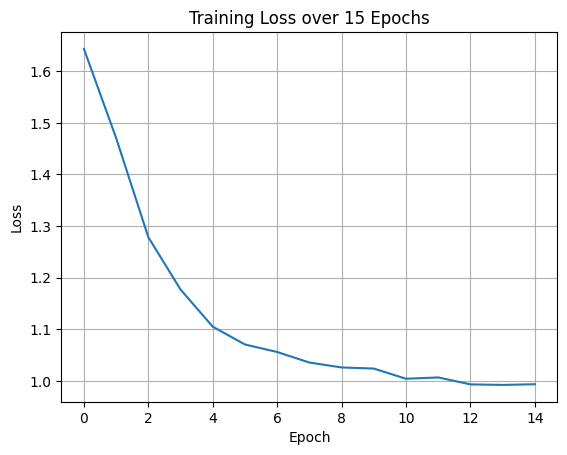

In [28]:
train_KVMemNet(model, optimizer, criterion, train_data, num_epochs, device)

In [29]:
# Testing
def test_KVMemNet(model, test_data, device):
    model.eval()

    correct_pred = 0
    total_sample = 0
    random.seed(100)

    for people_index in range(len(test_data)):
        batch_data = test_data[people_index]

        # Add random data
        random_person_1 = test_data[random.randint(0, len(test_data)-1)]
        random_person_2 = test_data[random.randint(0, len(test_data)-1)]
        concatenate = batch_data + random_person_1 + random_person_2
        #concatenate = batch_data

        keys = [multihot(item[1], reduced_VOCAB) for item in concatenate]
        values = [multihot(item[2], reduced_VOCAB) for item in concatenate]

        keys = torch.stack([torch.tensor(k, dtype=torch.float32) for k in keys]).unsqueeze(0).to(device)
        values = torch.stack([torch.tensor(v, dtype=torch.float32) for v in values]).unsqueeze(0).to(device)

        with torch.no_grad():

            y_embed = model.embedding_B(values.clone()).squeeze(0)

            for relation_index in range(len(batch_data)):
                question = keys[0][relation_index].unsqueeze(0).to(device)

                output = model(question, keys, values).squeeze(0)
                attention_score = torch.nn.functional.softmax(torch.inner(y_embed, output), dim=0)

                target_index = relation_index
                predicted_index = torch.argmax(attention_score).item()

                # Accuracy tracking
                if predicted_index == target_index:
                    correct_pred += 1
                total_sample += 1

    # Test Accuracy
    accuracy = correct_pred / total_sample
    print(f"Test Accuracy: {accuracy*100:.2f}%")
    return accuracy*100

In [30]:
acc_multihot = test_KVMemNet(model, test_data, device)

Test Accuracy: 73.37%


In [31]:
# Save trained model to Google Drive
# https://docs.pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html
torch.save(model.state_dict(), "/content/drive/MyDrive/NLP/KVMemNet.pth")

# Step 5: Evaluate Model Results with QA Function - Multihot

Given a natural language question:
1. Convert the question into a bag-of-words vector using the shared vocabulary.
2. Select a set of relevant (key, value) memory pairs from the database to serve as context.
3. Feed the question and the memory pairs into the trained KVMemNet model.
4. Obtain an output vector from the model and use it to compute attention scores over the values.
5. Select the value with the highest attention score.
6. Return the original string form of that value as the model’s answer.
This final output should match the natural language answer to the question.

**Note** The natural language answer returned by the QA function includes the person's name, which is also present in the original question. This is a result of the way the input dataset was constructed.

Because of this structure, evaluating the model’s output is straightforward:
- If the name in the model's answer does not match the name in the question, the answer is **definitively incorrect**.

In [32]:
# Load trained model from Google Drive
model.load_state_dict(torch.load("/content/drive/MyDrive/NLP/KVMemNet.pth", map_location=device))

<All keys matched successfully>

In [33]:
# Create the Question-Answer (QA) function
def QA(model, question_text, keys, values, concatanate, device):
    model.eval()

    question = multihot(question_text, reduced_VOCAB)
    question_tensor = torch.tensor(question, dtype=torch.float32).unsqueeze(0).to(device)

    keys_tensor = torch.stack([torch.tensor(k, dtype=torch.float32) for k in keys]).unsqueeze(0).to(device)
    values_tensor = torch.stack([torch.tensor(v, dtype=torch.float32) for v in values]).unsqueeze(0).to(device)

    with torch.no_grad():
        y_embed = model.embedding_B(values_tensor).squeeze(0)
        output = model(question_tensor, keys_tensor, values_tensor).squeeze(0)

        attention_score = torch.nn.functional.softmax(torch.inner(y_embed, output), dim=0)
        predicted_index = torch.argmax(attention_score).item()
        return concatanate[predicted_index][2]

## **Analyses**: Following are 3 correct results (**Ex1**, **Ex3**, **Ex5** ) and 3 incorrect results (**EX2**, **Ex4**, **Ex6**).

In [34]:
#----------------------------------------
# Ex1: QA function with correct output
#----------------------------------------
question_text = "What was mara thompson's birth date?"
ground_truth = DB['mara thompson']['birth_date']
concatenate = trimmed_DB[name_to_index['mara thompson']] + trimmed_DB[name_to_index['betty montgomery']] + trimmed_DB[name_to_index['william hague']]

keys = [multihot(item[1], reduced_VOCAB) for item in concatenate]
values = [multihot(item[2], reduced_VOCAB) for item in concatenate]

print(f"The question               : {question_text}")
answer = QA(model, question_text, keys, values, concatenate, device)
print(f"The answer from the model  : {answer}")

# Double-check the correct answer in DB
print(f"The ground-truth answer    : {ground_truth}")

res = 'Correct' if ground_truth in answer else 'Incorrect'
print()
print(f"The model output is {res}!")

The question               : What was mara thompson's birth date?
The answer from the model  : mara thompson 4 october 1961
The ground-truth answer    : 4 october 1961

The model output is Correct!


In [35]:
#----------------------------------------
# Ex2: QA function with incorrect output
#----------------------------------------
question_text = "What was heinrich albertz's death date?"
ground_truth = DB['heinrich albertz']['death_date']
concatenate = trimmed_DB[name_to_index['harry holgate']] + trimmed_DB[name_to_index['heinrich albert']] + trimmed_DB[name_to_index['heinrich albertz']]

keys = [multihot(item[1], reduced_VOCAB) for item in concatenate]
values = [multihot(item[2], reduced_VOCAB) for item in concatenate]

print(f"The question               : {question_text}")
answer = QA(model, question_text, keys, values, concatenate, device)
print(f"The answer from the model  : {answer}")

# Double-check the correct answer in DB
print(f"The ground-truth answer    : {ground_truth}")

res = 'Correct' if ground_truth in answer else 'Incorrect'
print()
print(f"The model output is {res}!")

The question               : What was heinrich albertz's death date?
The answer from the model  : heinrich albert 1 november 1960
The ground-truth answer    : 18 may 1993

The model output is Incorrect!


**Ex1**: The plausible candidates for the question have **distinct names**, and the question contains the keyword ***birth date*** for the target key-value pair. These factors help the model yield the correct result.

**Ex2**: It has two **similar names**. Even though the question also includes the keyword ***death date***, the high similarity between **"heinrich albert"** and **"heinrich albertz"** confuses the model and hence leads to the incorrect answer.

In [36]:
#----------------------------------------
# Ex3: QA function with correct output
#----------------------------------------

question_text = "What was jon tester's birth date?"
ground_truth = DB['jon tester']['birth_date']
concatenate = trimmed_DB[name_to_index['jon tester']] + trimmed_DB[name_to_index['ana botella']] + trimmed_DB[name_to_index['james seddon']]

keys = [multihot(item[1], reduced_VOCAB) for item in concatenate]
values = [multihot(item[2], reduced_VOCAB) for item in concatenate]

print(f"The question               : {question_text}")
answer = QA(model, question_text, keys, values, concatenate, device)
print(f"The answer from the model  : {answer}")

# Double-check the correct answer in DB
print(f"The ground-truth answer    : {ground_truth}")

res = 'Correct' if ground_truth in answer else 'Incorrect'
print()
print(f"The model output is {res}!")

The question               : What was jon tester's birth date?
The answer from the model  : jon tester 21 august 1956
The ground-truth answer    : 21 august 1956

The model output is Correct!


In [37]:
#----------------------------------------
# Ex4: QA function with incorrect output
#----------------------------------------

question_text = "When was jon tester born?"
ground_truth = DB['jon tester']['birth_date']
concatenate = trimmed_DB[name_to_index['jon tester']] + trimmed_DB[name_to_index['ana botella']] + trimmed_DB[name_to_index['james seddon']]

keys = [multihot(item[1], reduced_VOCAB) for item in concatenate]
values = [multihot(item[2], reduced_VOCAB) for item in concatenate]

print(f"The question               : {question_text}")
answer = QA(model, question_text, keys, values, concatenate, device)
print(f"The answer from the model  : {answer}")

# Double-check the correct answer in DB
print(f"The ground-truth answer    : {ground_truth}")

res = 'Correct' if ground_truth in answer else 'Incorrect'
print()
print(f"The model output is {res}!")

The question               : When was jon tester born?
The answer from the model  : jon tester congregationalism
The ground-truth answer    : 21 august 1956

The model output is Incorrect!


**Ex3** and **Ex4**: They use the same candidates and similar questions, but different phrasings.

**Ex3** uses the keyword ***birth date*** and yields the correct result.

**Ex4** uses ***born*** instead of ***birth date***, which is natural in real-world question-answering scenarios. However, the model lacks semantic understanding and cannot associate ***birth date*** and ***born*** as related terms. As a result, it outputs the incorrect answer.

In [38]:
#----------------------------------------
# Ex5: QA function with correct output
#----------------------------------------

question_text = "What was jon tester's religion?"
ground_truth = DB['jon tester']['religion']
concatenate = trimmed_DB[name_to_index['jon tester']] + trimmed_DB[name_to_index['ana botella']] + trimmed_DB[name_to_index['james seddon']]

keys = [multihot(item[1], reduced_VOCAB) for item in concatenate]
values = [multihot(item[2], reduced_VOCAB) for item in concatenate]

print(f"The question               : {question_text}")
answer = QA(model, question_text, keys, values, concatenate, device)
print(f"The answer from the model  : {answer}")

# Double-check the correct answer in DB
print(f"The ground-truth answer    : {ground_truth}")

res = 'Correct' if ground_truth in answer else 'Incorrect'
print()
print(f"The model output is {res}!")


The question               : What was jon tester's religion?
The answer from the model  : jon tester congregationalism
The ground-truth answer    : congregationalism

The model output is Correct!


In [39]:
#----------------------------------------
# Ex6: QA function with incorrect output
#----------------------------------------

question_text = "What was manser marmion's religion?"
if 'religion' in DB['manser marmion']:
    ground_truth = DB['manser marmion']['religion']
else:
    ground_truth = 'Not exist'
concatenate = trimmed_DB[name_to_index['jon tester']] + trimmed_DB[name_to_index['ana botella']] + trimmed_DB[name_to_index['manser marmion']]

keys = [multihot(item[1], reduced_VOCAB) for item in concatenate]
values = [multihot(item[2], reduced_VOCAB) for item in concatenate]

print(f"The question               : {question_text}")
answer = QA(model, question_text, keys, values, concatenate, device)
print(f"The answer from the model  : {answer}")

# Double-check the correct answer in DB
print(f"The ground-truth answer    : {ground_truth}")

res = 'Correct' if ground_truth in answer else 'Incorrect'
print()
print(f"The model output is {res}!")

The question               : What was manser marmion's religion?
The answer from the model  : ana botella roman catholic
The ground-truth answer    : Not exist

The model output is Incorrect!


**Ex5** and **Ex6**: Their questions use the same keyword ***religion***, but the candidate contents are slightly different.

**Ex5** has valid values for the keyword across all candidates.

**Ex6** has one candidate (which is also the queried entity) that lacks a key-value pair for the keyword. Since the model has no mechanism to handle missing data, it returns an incorrect answer.

# Step 6: GloVe Embedding

GloVe embeddings (also referred to as **embeddings** in the remainder of this project) assign a unique vector representation to each word based on its co-occurrence statistics in a large corpus. Words that appear in similar contexts will have similar embeddings, capturing semantic similarity. This step investigates whether these semantic relationships can help the model improve its performance and solve the incorrect cases **Ex2** and **Ex4** in Step 4 more effectively.

In [40]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-08-10 22:40:24--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-08-10 22:40:24--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-08-10 22:40:24--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [41]:
def load_glove_embeddings(glove_path):
    glove = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vector = torch.tensor([float(x) for x in parts[1:]], dtype=torch.float32)
            glove[word] = vector
    return glove

In [42]:
def create_embedding_matrix(vocab, glove, embed_dim):
    matrix = torch.randn(vocab.num_words(), embed_dim)  # Random init
    for word in vocab.get_words():
        idx = vocab.word2index(word)
        if word in glove:
            matrix[idx] = glove[word]
    return matrix

### The similarity between ***birth*** and ***born*** is 0.5217, which indicates a moderate semantic similarity.

In [43]:
glove_path = "glove.6B.100d.txt"
glove_dict = load_glove_embeddings(glove_path)
word1, word2 = 'birth', 'born'
vec1, vec2 = glove_dict[word1], glove_dict[word2]

sim = F.cosine_similarity(vec1.unsqueeze(0), vec2.unsqueeze(0)).item()
print(f"Similarity ({word1} vs {word2}): {sim:.4f}")

Similarity (birth vs born): 0.5217


## Modify Key-Value Memory Network for GloVe

In [44]:
'''
KVMemNet_Embedding model is defined in private_models.PrivateModels for this project.
The implementation is hidden for academic integrity.
'''
KVMemNet_Embedding = PrivateModels.KVMemNet_Embedding

In [45]:
# Set up Key-Value Memory Network
glove_path = "glove.6B.100d.txt"
freeze_embeddings = False  # fine-tune GloVe
vocab_size = reduced_VOCAB.num_words()
embed_size = 100
learning_rate = 0.01
num_epochs = 15

# Load GloVe
glove_dict = load_glove_embeddings(glove_path)

# Create embedding matrix
embedding_matrix = create_embedding_matrix(reduced_VOCAB, glove_dict, embed_size)

model_embed = KVMemNet_Embedding(vocab_size=vocab_size, embed_dim=embed_size, embedding_matrix=embedding_matrix, freeze=freeze_embeddings).to(device)
optimizer_embed = optim.Adam(model_embed.parameters(), lr=learning_rate)
criterion_embed = nn.CrossEntropyLoss()

In [46]:
# Training
def train_KVMemNet_Embedding(model_embed, optimizer_embed, criterion_embed, train_data, num_epochs, device):
    model_embed.train()

    epoch_losses = []
    epoch_accuracies = []
    epoch_times = []
    for epoch in range(num_epochs):
        start_time = time.time()
        losses = []
        correct_pred = 0
        total_sample = 0
        random.seed(epoch)

        for people_index in range(len(train_data)):
            batch_data = train_data[people_index]

            # Add random data
            random_person_1 = train_data[random.randint(0, len(train_data) - 1)]
            random_person_2 = train_data[random.randint(0, len(train_data) - 1)]
            concatenate = batch_data + random_person_1 + random_person_2

            # Convert words to index tensors for keys/values
            keys = [torch.tensor([reduced_VOCAB.word2index(w) for w in item[1]], dtype=torch.long) for item in concatenate]
            values = [torch.tensor([reduced_VOCAB.word2index(w) for w in item[2]], dtype=torch.long) for item in concatenate]

            # Pad sequences to same length, result shape: [1, N, max_len]
            keys = pad_sequence(keys, batch_first=True).unsqueeze(0).to(device)
            values = pad_sequence(values, batch_first=True).unsqueeze(0).to(device)

            y_embed = model_embed.embedding_B(values.clone()).mean(dim=2).squeeze(0).detach()

            for relation_index in range(len(batch_data)):
                question = torch.tensor([reduced_VOCAB.word2index(w) for w in batch_data[relation_index][1]], dtype=torch.long).unsqueeze(0).to(device)

                output = model_embed(question, keys, values).squeeze(0)
                attention_score = torch.nn.functional.softmax(torch.inner(y_embed, output), dim=0)

                target_index = relation_index
                predicted_index = torch.argmax(attention_score).item()

                # Compute loss
                target_tensor = torch.tensor([target_index], dtype=torch.long).to(device)
                loss = criterion_embed(attention_score.unsqueeze(0), target_tensor)
                losses.append(loss)

                # Backprop & optimize
                optimizer_embed.zero_grad()
                loss.backward()
                optimizer_embed.step()

                # Accuracy tracking
                if predicted_index == target_index:
                    correct_pred += 1
                total_sample += 1

        end_time = time.time()
        epoch_time = end_time - start_time
        epoch_times.append(epoch_time)
        # Compute each epoch accuracy, loss & stack for loss plot
        epoch_loss = torch.stack(losses).mean().item()
        epoch_accuracy = correct_pred / total_sample
        print(f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy*100:.2f}%, Runtime: {epoch_time:.2f} seconds")
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)

    print(f"Average Accuracy over {num_epochs} Epochs: {sum(epoch_accuracies)/len(epoch_accuracies)*100:.2f}%")
    print(f"Average runtime over {num_epochs} Epochs: {sum(epoch_times)/len(epoch_times):.2f}s")

    # Loss plot
    plt.figure()
    plt.clf()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training Loss over {num_epochs} Epochs")
    plt.plot(epoch_losses)
    plt.grid()
    plt.show()

Epoch 1/15 Loss: 1.5822, Accuracy: 36.77%, Runtime: 52.16 seconds
Epoch 2/15 Loss: 1.3970, Accuracy: 61.25%, Runtime: 53.10 seconds
Epoch 3/15 Loss: 1.2746, Accuracy: 72.74%, Runtime: 51.84 seconds
Epoch 4/15 Loss: 1.1910, Accuracy: 79.93%, Runtime: 49.84 seconds
Epoch 5/15 Loss: 1.1342, Accuracy: 85.61%, Runtime: 50.03 seconds
Epoch 6/15 Loss: 1.1034, Accuracy: 88.05%, Runtime: 52.14 seconds
Epoch 7/15 Loss: 1.0919, Accuracy: 88.75%, Runtime: 51.62 seconds
Epoch 8/15 Loss: 1.0812, Accuracy: 89.91%, Runtime: 52.09 seconds
Epoch 9/15 Loss: 1.0525, Accuracy: 92.46%, Runtime: 49.95 seconds
Epoch 10/15 Loss: 1.0672, Accuracy: 92.34%, Runtime: 50.81 seconds
Epoch 11/15 Loss: 1.0541, Accuracy: 92.11%, Runtime: 52.04 seconds
Epoch 12/15 Loss: 1.0396, Accuracy: 94.08%, Runtime: 49.92 seconds
Epoch 13/15 Loss: 1.0247, Accuracy: 94.66%, Runtime: 51.01 seconds
Epoch 14/15 Loss: 1.0247, Accuracy: 94.32%, Runtime: 54.90 seconds
Epoch 15/15 Loss: 1.0231, Accuracy: 95.94%, Runtime: 55.88 seconds
Aver

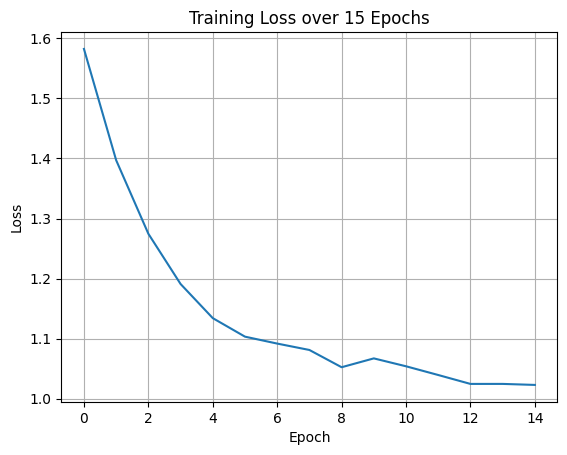

In [47]:
train_KVMemNet_Embedding(model_embed, optimizer_embed, criterion_embed, train_data, num_epochs, device)

In [48]:
# Testing
def test_KVMemNet_Embedding(model_embed, test_data, device):
    model_embed.eval()

    correct_pred = 0
    total_sample = 0
    random.seed(100)

    for people_index in range(len(test_data)):
        batch_data = test_data[people_index]

        # Add random data
        random_person_1 = test_data[random.randint(0, len(test_data) - 1)]
        random_person_2 = test_data[random.randint(0, len(test_data) - 1)]
        concatenate = batch_data + random_person_1 + random_person_2

        # Convert words to index tensors for keys/values
        keys = [torch.tensor([reduced_VOCAB.word2index(w) for w in item[1]], dtype=torch.long) for item in concatenate]
        values = [torch.tensor([reduced_VOCAB.word2index(w) for w in item[2]], dtype=torch.long) for item in concatenate]

        # Pad sequences to same length, result shape: [1, N, max_len]
        keys = pad_sequence(keys, batch_first=True).unsqueeze(0).to(device)
        values = pad_sequence(values, batch_first=True).unsqueeze(0).to(device)

        with torch.no_grad():
            y_embed = model_embed.embedding_B(values.clone()).mean(dim=2).squeeze(0).detach()

            for relation_index in range(len(batch_data)):
                question = torch.tensor([reduced_VOCAB.word2index(w) for w in batch_data[relation_index][1]], dtype=torch.long).unsqueeze(0).to(device)

                output = model_embed(question, keys, values).squeeze(0)
                attention_score = torch.nn.functional.softmax(torch.inner(y_embed, output), dim=0)

                target_index = relation_index
                predicted_index = torch.argmax(attention_score).item()

                # Accuracy tracking
                if predicted_index == target_index:
                    correct_pred += 1
                total_sample += 1

    # Test Accuracy
    accuracy = correct_pred / total_sample
    print(f"Test Accuracy: {accuracy*100:.2f}%")
    return accuracy*100

In [49]:
acc_embedding = test_KVMemNet_Embedding(model_embed, test_data, device)

Test Accuracy: 93.49%


In [50]:
# Save trained model_embed to Google Drive
# https://docs.pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html
torch.save(model_embed.state_dict(), "/content/drive/MyDrive/NLP/KVMemNet_embed.pth")

# Step 7: Evaluate Model Results with QA Function - Embedding

This step runs the training loop for the embedding-based model, following the same structure as **Step 5** but replacing the multihot representation with GloVe embeddings.

In [51]:
# Load trained model_embed from Google Drive
model_embed.load_state_dict(torch.load("/content/drive/MyDrive/NLP/KVMemNet_embed.pth", map_location=device))

<All keys matched successfully>

In [52]:
# Create the Question–Answer (QA) function — for Embedding (GloVe)
def clean_question(q):
    # Lowercase
    q = q.lower()
    # Replace possessives (e.g., "mara thompson's" → "mara thompson")
    q = re.sub(r"'s\b", "", q)
    # Remove punctuation
    q = re.sub(r"[^a-z0-9\s]", "", q)
    # Tokenize
    return q.strip().split()

def QA_Embedding(model_embed, question_text, concatenated, device):
    model_embed.eval()

    # Tokenize question if needed
    if isinstance(question_text, str):
        #question_text = question_text.lower().split()
        question_text = clean_question(question_text)

    # Convert question to indices
    question_indices = [reduced_VOCAB.word2index(w) for w in question_text]
    question_tensor = torch.tensor(question_indices, dtype=torch.long).unsqueeze(0).to(device)  # [1, q_len]

    # Extract keys and values from concatenated
    keys = [item[1] for item in concatenated]
    values = [item[2] for item in concatenated]

    keys_indices = [torch.tensor([reduced_VOCAB.word2index(w) for w in k], dtype=torch.long) for k in keys]
    values_indices = [torch.tensor([reduced_VOCAB.word2index(w) for w in v], dtype=torch.long) for v in values]

    keys_tensor = pad_sequence(keys_indices, batch_first=True).unsqueeze(0).to(device)     # [1, N, max_len]
    values_tensor = pad_sequence(values_indices, batch_first=True).unsqueeze(0).to(device) # [1, N, max_len]

    with torch.no_grad():
        # Compute average value embeddings
        y_embed = model_embed.embedding_B(values_tensor.clone()).mean(dim=2).squeeze(0)  # [N, embed_dim]

        # Compute model output vector
        output = model_embed(question_tensor, keys_tensor, values_tensor).squeeze(0)  # [embed_dim]

        # Compute attention and select answer
        attention_score = torch.nn.functional.softmax(torch.inner(y_embed, output), dim=0)
        predicted_index = torch.argmax(attention_score).item()

    return concatenated[predicted_index][2]

## **Analyses**: Evaluate embedding on cases of **Ex1** to **Ex4** in **Step 4**, which correspond to **Ex7** to **Ex10** in this section.

For example, **Ex7** evaluates the embedding method using the same question and key–value pairs as in **Ex1**.

**Ex8** does the same for **Ex2**, and so on for the remaining examples.

In [53]:
#--------------------------------------------
# Ex7: QA function with correct output (Embedding)
#--------------------------------------------
question_text = "What was mara thompson's birth date?"
ground_truth = DB['mara thompson']['birth_date']
concatenate = trimmed_DB[name_to_index['mara thompson']] + trimmed_DB[name_to_index['betty montgomery']] + trimmed_DB[name_to_index['william hague']]

# Convert keys and values into list of word index sequences
keys = [item[1] for item in concatenate]      # list of word lists (key sentences)
values = [item[2] for item in concatenate]    # list of word lists (value sentences)

# Print question
print(f"The question             : {question_text}")

# Run QA model
answer = QA_Embedding(model_embed, question_text, concatenate, device)
print(f"The answer from the model: {answer}")

# Ground truth
print(f"The ground-truth answer  : {ground_truth}")

# Accuracy check
res = 'Correct' if ground_truth in answer else 'Incorrect'
print()
print(f"The model output is {res}!")

The question             : What was mara thompson's birth date?
The answer from the model: mara thompson 4 october 1961
The ground-truth answer  : 4 october 1961

The model output is Correct!


In [54]:
#--------------------------------------------
# Ex8: QA function with incorrect output (Embedding)
#--------------------------------------------
question_text =  "What was heinrich albertz's death date?"
ground_truth = DB['heinrich albertz']['death_date']
concatenate = trimmed_DB[name_to_index['harry holgate']] + trimmed_DB[name_to_index['heinrich albert']] + trimmed_DB[name_to_index['heinrich albertz']]

# Convert keys and values to list of word index sequences
keys = [item[1] for item in concatenate]
values = [item[2] for item in concatenate]

# Print question
print(f"The question             : {question_text}")

# Run QA model
answer = QA_Embedding(model_embed, question_text, concatenate, device)
print(f"The answer from the model: {answer}")

# Ground truth
print(f"The ground-truth answer  : {ground_truth}")

# Accuracy check
res = 'Correct' if ground_truth in answer else 'Incorrect'
print()
print(f"The model output is {res}!")

The question             : What was heinrich albertz's death date?
The answer from the model: heinrich albert 12 february 1874
The ground-truth answer  : 18 may 1993

The model output is Incorrect!


For both **Ex7** (corresponding to **Ex1**) and **Ex8** (corresponding to **Ex2**), the embedding method produced identical results to the multihot baseline—correct for **Ex7** and incorrect for **Ex8**. This indicates that, in these cases, using embeddings did not improve model performance or resolve errors caused by name similarity.

In [55]:
#===========================================
# Ex9: QA function with correct output (Embedding version)
#===========================================
question_text = "What was jon tester's birth date?"
ground_truth = DB['jon tester']['birth_date']
concatenate = trimmed_DB[name_to_index['jon tester']] + trimmed_DB[name_to_index['ana botella']] + trimmed_DB[name_to_index['james seddon']]

# Convert keys and values to list of word index sequences
keys = [item[1] for item in concatenate]
values = [item[2] for item in concatenate]

# Print question
print(f"The question             : {question_text}")

# Run QA model
answer = QA_Embedding(model_embed, question_text, concatenate, device)
print(f"The answer from the model: {answer}")

# Ground truth
print(f"The ground-truth answer  : {ground_truth}")

# Accuracy check
res = 'Correct' if ground_truth in answer else 'Incorrect'
print()
print(f"The model output is {res}!")

The question             : What was jon tester's birth date?
The answer from the model: jon tester 21 august 1956
The ground-truth answer  : 21 august 1956

The model output is Correct!


In [56]:
#===========================================
# Ex10: QA function with correct output (Embedding version)
#===========================================
question_text = "When was jon tester born?"
ground_truth = DB['jon tester']['birth_date']
concatenate = trimmed_DB[name_to_index['jon tester']] + trimmed_DB[name_to_index['ana botella']] + trimmed_DB[name_to_index['james seddon']]

# Convert keys and values to list of word index sequences
keys = [item[1] for item in concatenate]
values = [item[2] for item in concatenate]

# Print question
print(f"The question             : {question_text}")

# Run QA model
answer = QA_Embedding(model_embed, question_text, concatenate, device)
print(f"The answer from the model: {answer}")

# Ground truth
print(f"The ground-truth answer  : {ground_truth}")

# Accuracy check
res = 'Correct' if ground_truth in answer else 'Incorrect'
print()
print(f"The model output is {res}!")

The question             : When was jon tester born?
The answer from the model: jon tester 21 august 1956
The ground-truth answer  : 21 august 1956

The model output is Correct!


For **Ex9** (corresponding to **Ex3**) , the embedding method produced the same correct result as the multihot baseline.

For **Ex10** (corresponding to **Ex4**), embeddings improved performance by producing the correct answer where the multihot method had previously failed. This suggests that GloVe embeddings provided useful semantic information that helped the model generalize better in this case, likely because the word vectors capture relationships between terms beyond exact keyword matches.

# **Discussion**: Multihot vs. Embedding Performance

In [57]:
display(HTML(
    f"""
    <p style="font-size:16px; font-weight:400; line-height:1.35; margin:0.5rem 0;">
      The results indicate a substantial performance gap between the
      <strong>multihot baseline</strong> ({acc_multihot:.2f}% test accuracy) and the
      <strong>GloVe embedding</strong> method ({acc_embedding:.2f}% test accuracy).
    </p>
    """
))

**GloVe embeddings** significantly improved accuracy with a moderate increase in training time. The **GloVe embedding model** achieved higher accuracy and stronger generalization. The **multihot baseline** is simpler and faster but less robust to distractors.

The multihot representation encodes only the presence or absence of words in a high-dimensional sparse vector. While this approach is simple and computationally inexpensive, it lacks semantic understanding — each word is treated as independent, so it cannot recognize relationships between synonymous or related terms (e.g., ***birth date*** vs. ***born***).

This limitation is clearly illustrated in **Ex4** and **Ex10**, where the multihot method failed because the query used ***born*** instead of ***birth date***, even though the underlying fact was the same. In contrast, the embedding model captured the semantic similarity between these terms, producing the correct answer.

Similarly, in **name similarity*** cases like **Ex2** and **Ex8**, both methods failed, indicating that while embeddings improve semantic matching, they may still be challenged by near-identical entity names in the candidate set.

Overall, embeddings outperform multihot by:

1. Capturing semantic relationships between words.
2. Reducing sparsity in the input representation.
3. Providing a denser, lower-dimensional space for attention scoring.

These advantages explain the higher accuracy and the ability to recover correct answers in scenarios where multihot fails.